# Prediction of region for new drill

It is necessary to decide a region for new drill for the GlavRosGosNeft mining company.

The data are provided by oil samples in three regions: in each 10,000 fields, where the quality of oil and the volume of its reserves were measured. It is necessary to build a machine learning model that will help determine the region where mining will bring the greatest profit. The task is to analyze possible profits and risks with the *Bootstrap technique.*

<h1>Table of contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data preprocessing</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Training and testing of models</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Preparation for profit calculation</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Calculation of profit and risks</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">5&nbsp;&nbsp;</span>Final conclusions</a></span></li></ul></div>

***Data description***


id — the unique identifier of the well;


f0, f1, f2 — three signs of dots (it doesn't matter what they mean, but the signs themselves are significant);


product — the volume of reserves in the drill (thousand barrels).

**Task conditions:**


* Only linear regression is suitable for training the model (the rest are not predictable enough).


* During the exploration of the region, 500 points are explored, from which 200 best ones are selected for development using machine learning.


* The budget for the development of drills in the region is 10 billion rubles.


* At current prices, one barrel of raw materials brings 450 rubles of income. The income from each unit of the product is 450 thousand rubles, since the volume is indicated in thousands of barrels.


* After the risk assessment, we need to leave only those regions in which the probability of losses is less than 2.5%. Among them, the region with the highest average profit shall be chosen.

## 1. Data preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.utils import shuffle

In [2]:
# Disable the Anaconda warning
warnings.simplefilter('ignore')

# Default graph size
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9

# Setting the maximum number of columns in the dateframe to be displayed 
pd.set_option('display.max_columns',None)

In [3]:
#Let's upload data about drills in 3 regions
data_reg1 = pd.read_csv('geo_data_0.csv')
data_reg2 = pd.read_csv('geo_data_1.csv')
data_reg3 = pd.read_csv('geo_data_2.csv')


Let's start with exploratory analysis of each dataframe in the following order:

1) general information;

2) selective inspection of dataframe strings;

3) a general description of the spread of values and the presence of duplicates.

In [4]:
regions = {'data_reg1':data_reg1, 'data_reg2':data_reg2,'data_reg3':data_reg3}

In [5]:
def explore_data(name,data):
    print(f'General information about {name} dataframe')
    print()
    display(data.info())
    print()
    print(f'In {name} dataframe - {data.duplicated().sum()} duplicates are detected, which are - {data.duplicated().sum() / len(data)}%.')
    print()
    print(f"Let's look at the first 5 strings of {name} dataframe:")
    print()
    display(data.head())
    print()
    print(f'The last 5 strings of {name} dataframe:')
    display(data.tail())
    print()
    print(f"Let's look at the 5 eandomly selected strings of {name} dataframe")
    print()
    display(data.sample(5))
    print()
    display(data.describe().T)
    print()
    print('--------------------------------------------------------------------------------')
    print('********************************************************************************')
    print('--------------------------------------------------------------------------------')
    print()
    return
    

In [6]:
# We automate the initial data analysis of each dataframe
for key,value in regions.items():
    explore_data(key,value)
    

General information about data_reg1 dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


In data_reg1 dataframe - 0 duplicates are detected, which are - 0.0%.

Let's look at the first 5 strings of data_reg1 dataframe:



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



The last 5 strings of data_reg1 dataframe:


,id,f0,f1,f2,product
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764
99999,1CWhH,1.764754,-0.266417,5.722849,149.633246



Let's look at the 5 eandomly selected strings of data_reg1 dataframe



,id,f0,f1,f2,product
23948,ot9xw,0.211770,-0.382500,-2.594461,76.819519
83443,wPR0S,0.682769,-0.563984,0.247837,72.294181
49166,1aQWP,0.844311,-0.272351,8.931940,153.226015
67307,crOud,0.061487,0.154349,-2.588124,28.654455
73834,MKVTV,0.428875,-0.402908,1.328326,31.366862


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------

General information about data_reg2 dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


In data_reg2 dataframe - 0 duplicates are detected, which are - 0.0%.

Let's look at the first 5 strings of data_reg2 dataframe:



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



The last 5 strings of data_reg2 dataframe:


,id,f0,f1,f2,product
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364
99999,relB0,-3.426139,-7.794274,-0.003299,3.179103



Let's look at the 5 eandomly selected strings of data_reg2 dataframe



,id,f0,f1,f2,product
75969,8kcws,11.504240,-6.403361,0.990664,26.953261
2176,Y1Tqd,16.576789,-1.134803,4.998496,134.766305
82335,Ra6Bh,5.303215,-8.724593,-0.003020,0.000000
55415,J5GGQ,-5.877170,-1.252842,4.004560,110.992147
22284,h0sQj,-0.790071,-4.709598,4.992261,134.766305


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------

General information about data_reg3 dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None


In data_reg3 dataframe - 0 duplicates are detected, which are - 0.0%.

Let's look at the first 5 strings of data_reg3 dataframe:



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



The last 5 strings of data_reg3 dataframe:


,id,f0,f1,f2,product
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253
99999,V9kWn,-2.551421,-2.025625,6.090891,102.775767



Let's look at the 5 eandomly selected strings of data_reg3 dataframe



,id,f0,f1,f2,product
56879,Q4rCe,0.518478,-1.822007,3.537321,24.435729
63162,2hBEe,5.047931,0.951658,9.742654,162.762157
192,o2HFZ,2.409715,-1.855590,8.908628,117.367157
91245,0I3DT,-0.857999,0.097696,-0.867943,28.974311
40341,t8pki,4.952137,1.620811,4.938946,179.739949


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



--------------------------------------------------------------------------------
********************************************************************************
--------------------------------------------------------------------------------



1) there are no missing values and duplicates in all provided dataframes;


2) dataframe attributes have float64 data type, and **id** - object data type;


3) features values are widely distributed;


4) the column **id** of dataframes has no practical interest for further analysis, therefore **it is proposed to delete the column**.

In [7]:
# deleting the id column in dataframes
for name,region in regions.items():
    regions[name] = region.drop(['id'], axis=1)

In [8]:
# Checking for deletion
for name, region in regions.items():
    print(f'Dataframe - {name}')
    display(region.head(1))

Dataframe - data_reg1


,f0,f1,f2,product
0,0.705745,-0.497823,1.22117,105.280062


Dataframe - data_reg2


,f0,f1,f2,product
0,-15.001348,-8.276,-0.005876,3.179103


Dataframe - data_reg3


,f0,f1,f2,product
0,-1.146987,0.963328,-0.828965,27.758673


The deletion of the column **id** was made successfully.

Let's look at the distribution of features of each dataframe.

-----------------data_reg1 dataframe graph:-----------------



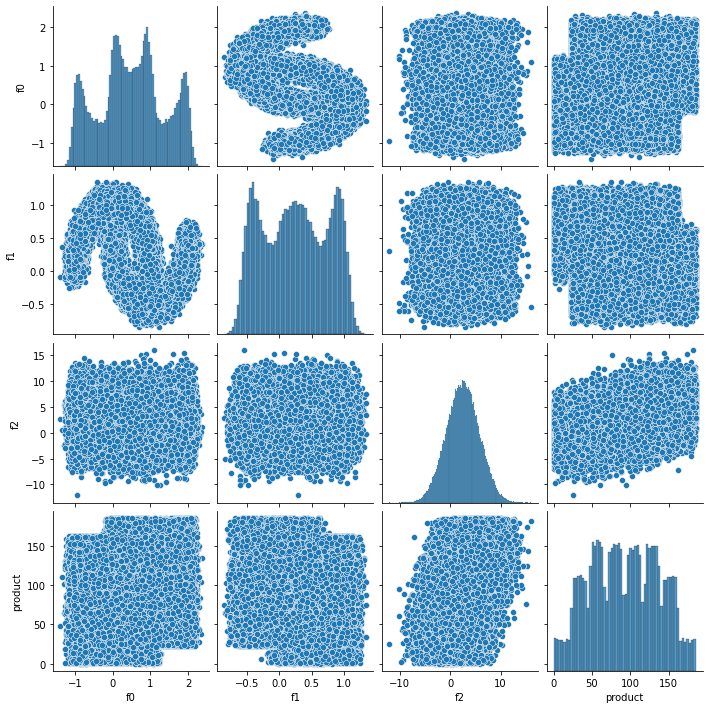


Let's draw heatmap for data_reg1 dataframe



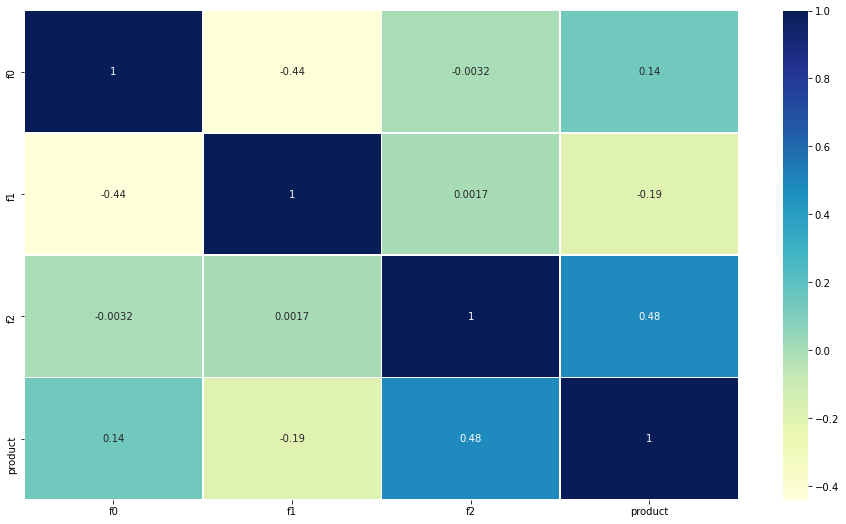


-----------------data_reg2 dataframe graph:-----------------



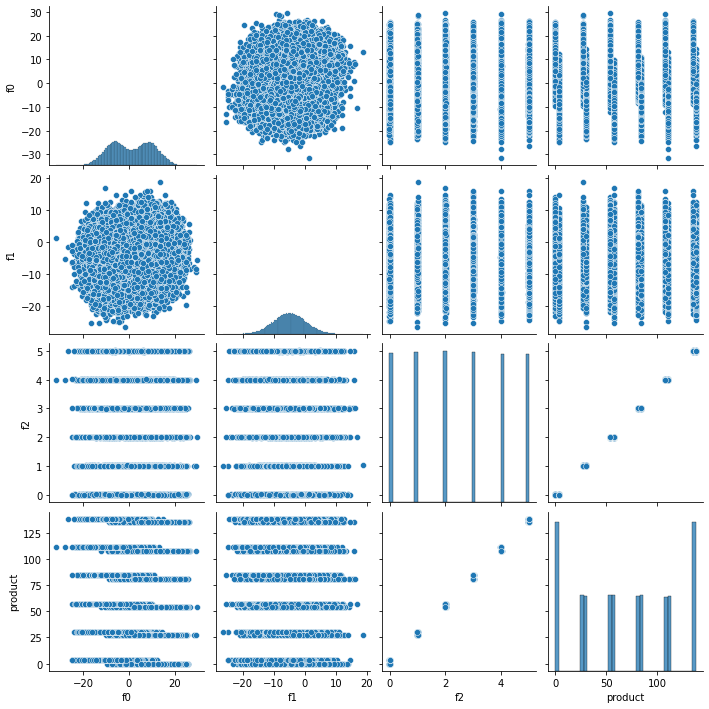


Let's draw heatmap for data_reg2 dataframe



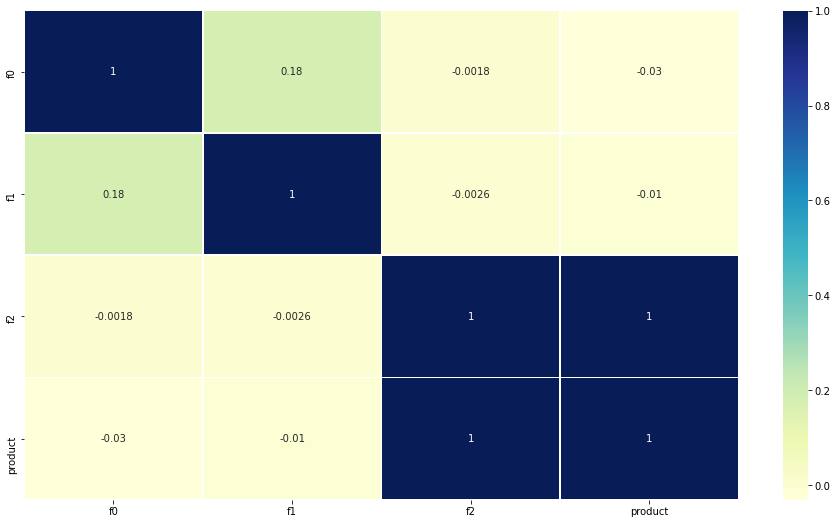


-----------------data_reg3 dataframe graph:-----------------



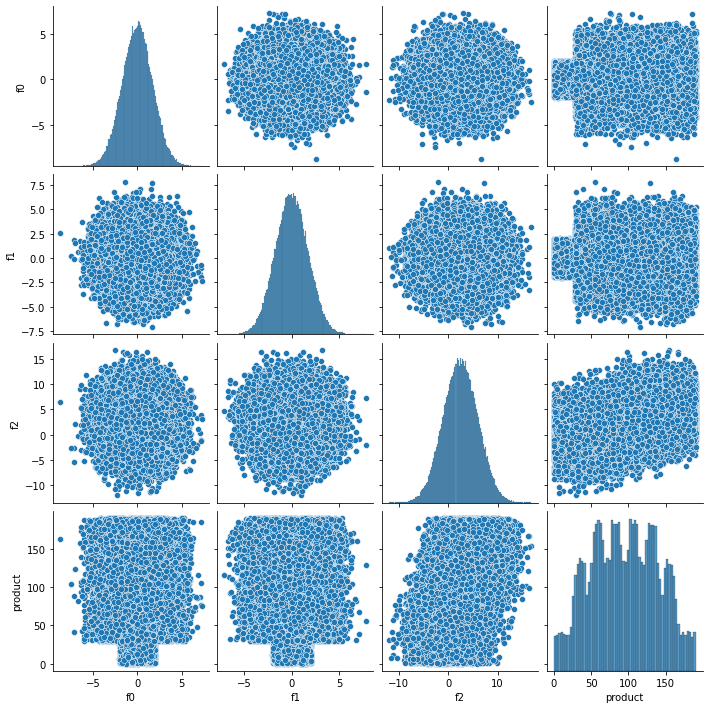


Let's draw heatmap for data_reg3 dataframe



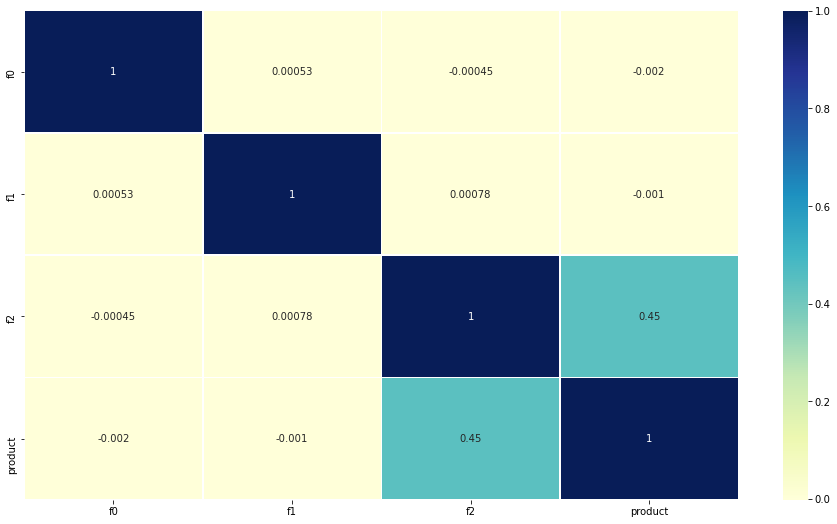

In [9]:
for name, region in regions.items():
    print(f'{name} dataframe graph:'.center(60,'-'))
    print()
    sns.pairplot(region)
    plt.show()
    print()
    print(f"Let's draw heatmap for {name} dataframe")
    print()
    sns.heatmap(region.corr(), annot=True, cmap="YlGnBu",linewidths=0.5)
    plt.show()
    print()

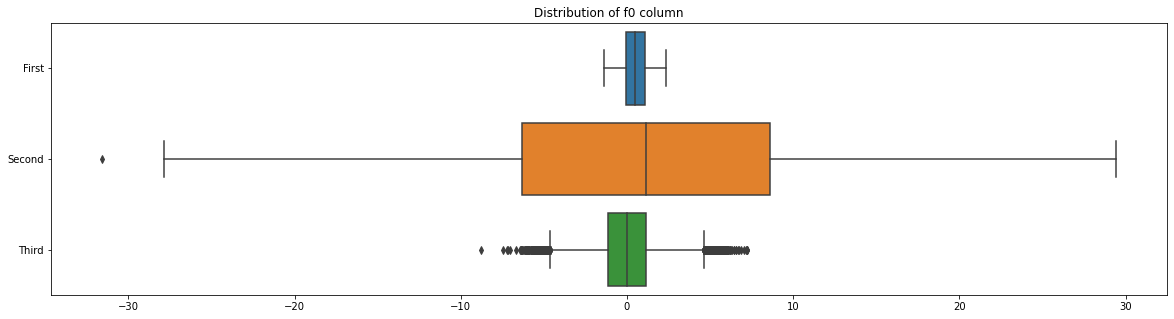

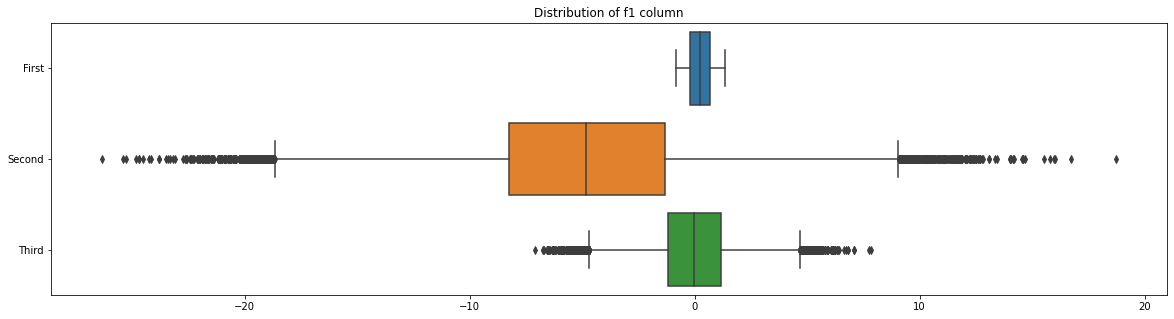

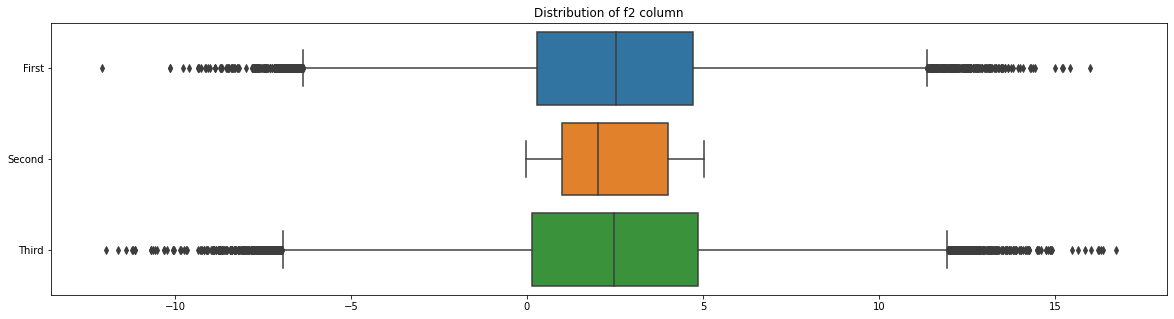

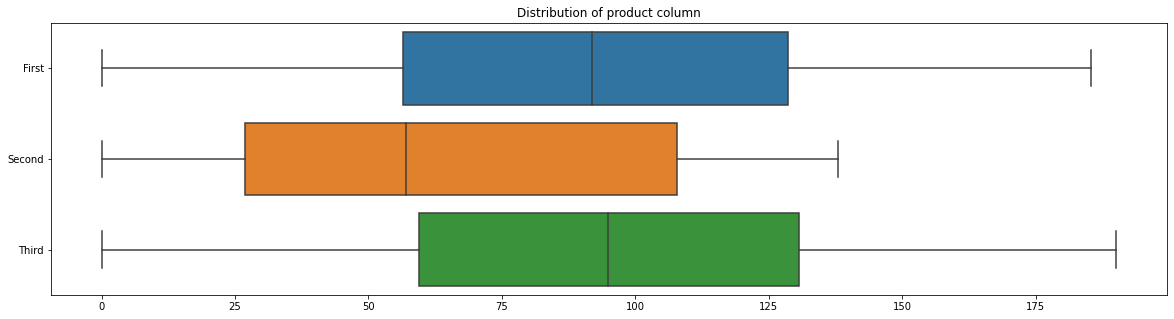

In [10]:
# Let's look at the distribution of the corresponding columns of each of the dataframes
for column in regions['data_reg1'].columns:
    for i in range(3):
        analize = pd.DataFrame({
        'First':regions['data_reg1'][column],
        'Second':regions['data_reg2'][column],
        'Third':regions['data_reg3'][column]})
    plt.figure(figsize=(20,5))
    sns.boxplot(data=analize, orient="h")
    plt.title(f'Distribution of {column} column')
    plt.show()

<div style="font-size: 20px">
    

**Intermediate conclusions**

1) The datafremes submitted for analysis contain 10,000 lines in which there are no missing values and duplicates;


2) each of them contains three features (fo,f1, f1), as well as id, which, due to the lack of practical interest for further analysis, has been deleted;


3) the data of all dataframes is widely distributed, while the distributions of the f2, product feature for the 1st and 3rd regions are close, and for the 2nd region, the f2 feature has a close average and a significantly smaller spread of values;


4) features f0, f1,f2 have practically no correlation with each other, however, significant indicators of positive correlation are observed for these signs with product;


5) the distribution of most features is normal, with the exception of the product feature in the second region, which is uniform with significant jumps at the edges of the distribution;


6) considering that the RMSE metric is sensitive to large values, and the spread of the values of the features f0,f1, f2 does not lie in the range [0,1] or [-1,1], it would be advisable to scale the data further.

## 2. Training and testing of models

In [11]:
# The function of dividing each of the dataframes into training and validation samples
def data_split(regions):
    
    scalers=[]
    models=[]
    predictions=[]
    targets_valid = []
    scores=[]
    rmses=[]
    
    # Let's create a dataframe to record the results
    data={'region':[],'model':[],'scaler':[],'rmse':[]}
    statistics = pd.DataFrame(data=data)
    
    # Let's divide each dataframe into training and validation samples
    regions_split = {}
    for name,region in regions.items():
        region_train, region_valid = train_test_split(region, train_size=0.75, random_state=12345, shuffle=True)
        
        # select features and target
        features_train = region_train.drop('product', axis=1)
        target_train = region_train['product']
        features_valid = region_valid.drop('product',axis=1)
        target_valid = region_valid['product']
        
        # Normalize the values of the features
        scaler=StandardScaler()
        features_train = pd.DataFrame(scaler.fit_transform(features_train),columns=features_train.columns)
        features_valid = pd.DataFrame(scaler.transform(features_valid),columns=features_train.columns)
        regions_split[name] = [features_train, target_train, features_valid, target_valid]
        
        # Let's build the model and train it
        model = LinearRegression()
        model.fit(features_train, target_train)
        
        #Recoridng of the results
        predicted_values = model.predict(features_valid)
        
        # Calculation of the error on the validation sample and RMSE
        score = mean_squared_error(target_valid, predicted_values)
        rmse = score**.5
        
        #Let's record the results, including predictions and correct answers
        scalers.append(scaler)
        models.append(model)
        scores.append(score)
        rmses.append(rmse)
        targets_valid.append({name:target_valid})
        predictions.append({name:predicted_values})
        
        #Writing down to the dataframe
        row_number=len(statistics)
        statistics.loc[row_number] = pd.Series([name,model,scaler,rmse], index=statistics.columns)
    return regions_split,models, rmses, predictions,targets_valid, scalers,statistics
    

In [12]:
regions_split, models, rmses, predictions, targets_valid, scalers, statistics = data_split(regions)

display(statistics)

,region,model,scaler,rmse
0,data_reg1,LinearRegression(),StandardScaler(),37.579422
1,data_reg2,LinearRegression(),StandardScaler(),0.893099
2,data_reg3,LinearRegression(),StandardScaler(),40.029709


<div style="font-size: 20px">
    

**Average stocks of predicted raw materials and RMSE of the model**

Region data_reg1
Average reserves of predicted raw materials 92.59256778438035 thousand barrels
RMSE 37.5794217150813


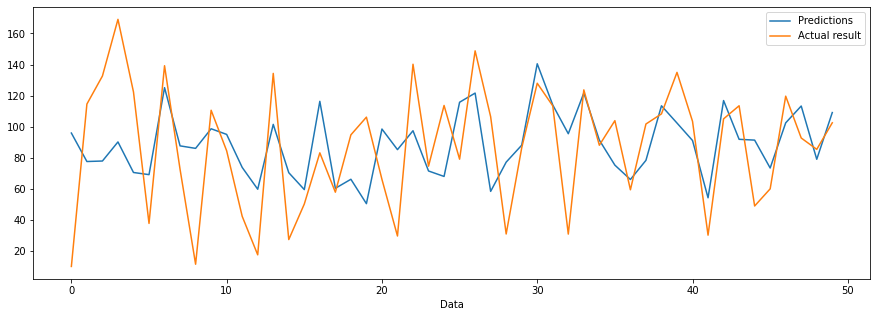

Region data_reg2
Average reserves of predicted raw materials 68.728546895446 thousand barrels
RMSE 0.8930992867756167


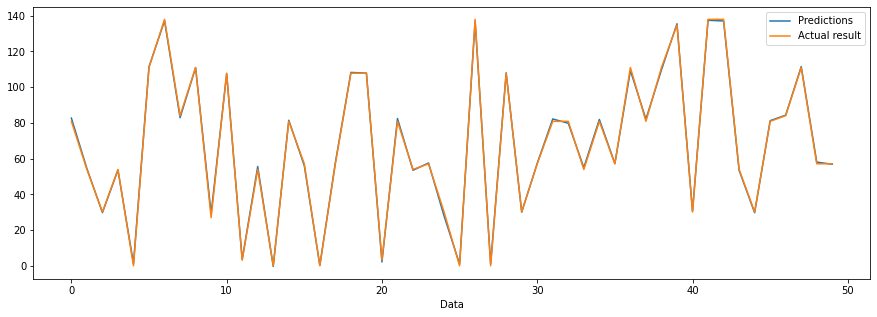

Region data_reg3
Average reserves of predicted raw materials 94.96504596800489 thousand barrels
RMSE 40.02970873393434


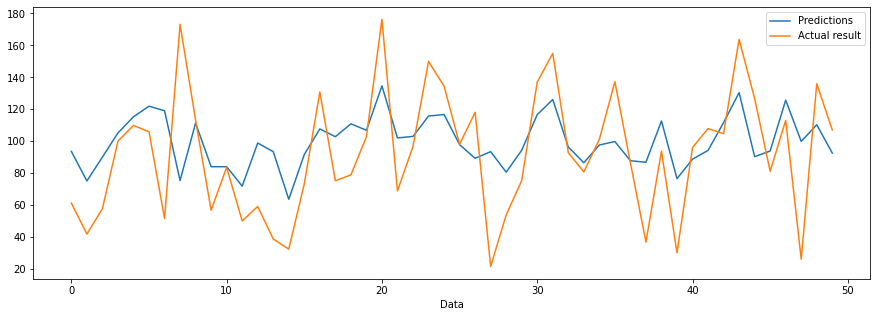

In [13]:
length = 50
counter = 0
for _ in range(len(predictions)):
    for key,value in predictions[_].items():
        print('Region {}'.format(key))
        print('Average reserves of predicted raw materials {} thousand barrels'.format(value.mean()))
        print('RMSE {}'.format(rmses[counter]))
        
    
        plt.figure(figsize=(15,5))
        plt.plot(value[:length], label='Predictions')
        plt.plot(list(targets_valid[counter][key] [:length]), label='Actual result')
        plt.legend()
        plt.xlabel('Data')
        counter+=1
        plt.show()
    
    

<div style="font-size: 20px">
    

**Intermediate conclusions:**

For the analysis of these regions in this section, the construction of three independent models was used. These parameters were previously normalized, since the features f0, f1, f2 did not lie in the range of acceptable values. The results clearly show that the 3rd and 1st regions are leading in terms of raw material reserves, however, the RMSE metric in these regions is significantly far from acceptable values. The most accurate forecasts are obtained for the model of the 2nd region, in which the RMSE metric is 0.8930992867756158.

## 3.  Preparation for profit calculation

In [14]:
# Budget for the development of drills in one region
BUDGET = 10000000000

# The number of points in the exploration of the region
RESEARCH_POINTS = 500

# The number of the best points for calculating profit
BEST_AMOUNT = 200

# Revenue per 1,000 barrels
REVENUE_PER_THOUSAND_BARREL = 450000

# Maximum risk
MAX_RISK = 0.025

# The cost of developing one drill
POINT_COST = BUDGET / BEST_AMOUNT

In [15]:
break_even_point = BUDGET / REVENUE_PER_THOUSAND_BARREL / BEST_AMOUNT

print('Sufficient volume of raw materials in the drill to breakeven: {:.3f} thousand barrels'.format(break_even_point))

Sufficient volume of raw materials in the drill to breakeven: 111.111 thousand barrels


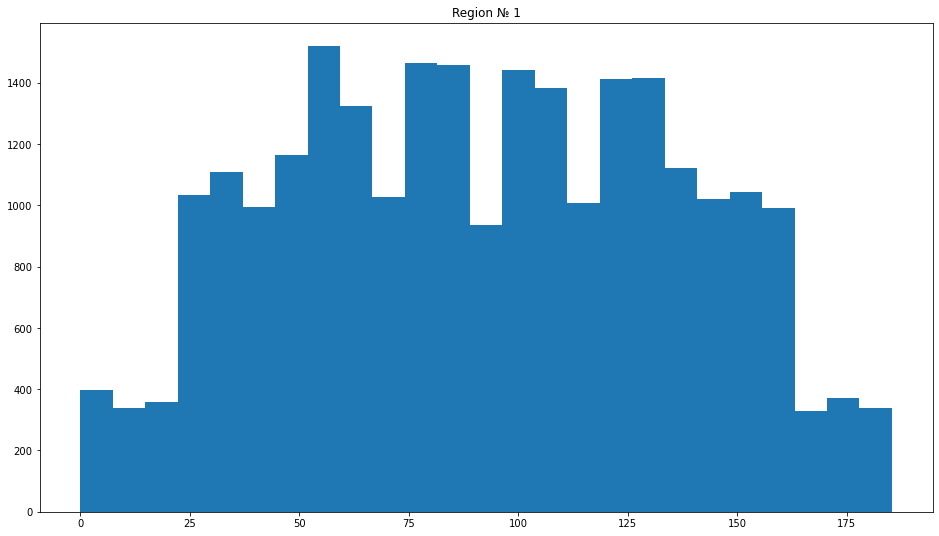

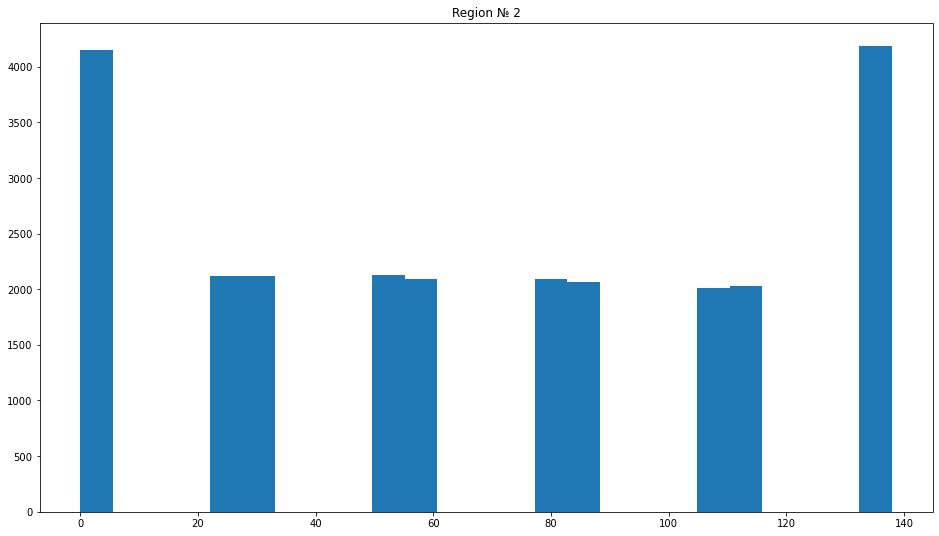

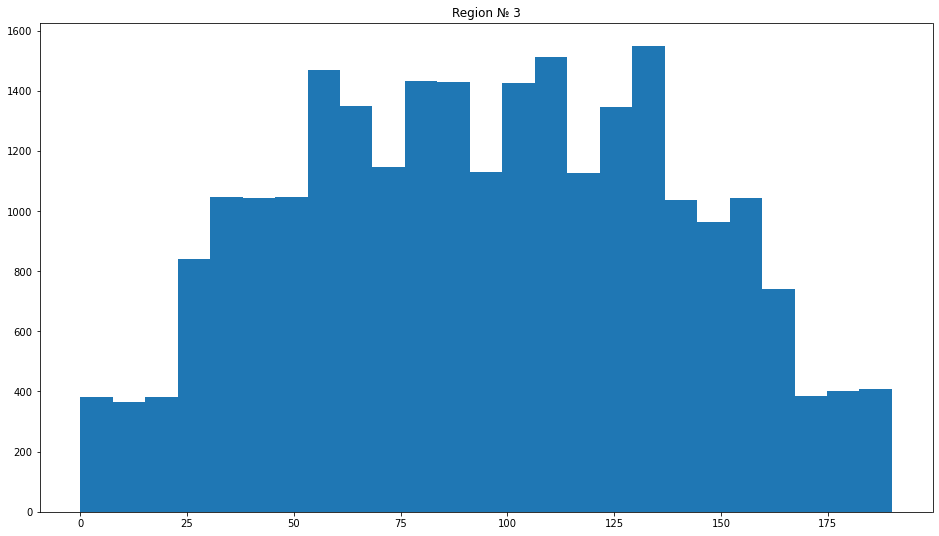

In [16]:
counter = 1
for i in targets_valid:
    for key, value in i.items():
        plt.title('Region № {}'.format(counter))
        plt.hist(value, bins=25)
        plt.show()
        counter +=1

<div style="font-size: 20px">
    

**Intermediate conclusions:**

Taking into account the fact that the average reserves of raw materials in the region are 92.59; 68.73; 94.97 thousand barrels, and the break-even volume starts from 111.111 thousand barrels, then it is not worth relying on random selection when choosing drills, since there was a risk of losses.

## 4.  Calculation of profit and risks 

In [17]:
def profit_math(actual_sample, predicted_sample, best_amount):
    # Sorting predictions
    predicted_sorted = predicted_sample.sort_values(ascending=False)
    # Let's sum up our actual volume values and find revenue from the region
    revenue = (actual_sample.loc[predicted_sorted.index][:BEST_AMOUNT].sum() * REVENUE_PER_THOUSAND_BARREL)
    # Gross profit=turnover-cost (cost of the drill)
    gross_profit = revenue - POINT_COST * BEST_AMOUNT
    return gross_profit

# Bootstrap for our regions
state = np.random.RandomState(12345)
bootstrap = 1000

for i in range(len(predictions)):
    for key,value in predictions[i].items():
        net_profit_list = []
        dataset = pd.DataFrame({'Predictions':value, 'Actual results':targets_valid[i][key]})
        
        
        
        for k in range(bootstrap):
            predicted_sample = dataset['Predictions'].sample(n=RESEARCH_POINTS,
                                                     replace=False,
                                                     random_state=state)
            actual_sample = dataset.loc[predicted_sample.index,'Actual results']
        
            net_profit_list.append(profit_math(actual_sample,
                                                   predicted_sample,
                                                   BEST_AMOUNT))
        net_profit_series=pd.Series(net_profit_list)
    
        loss_probability = (len(net_profit_series[net_profit_series < 0]) / 
                       len(net_profit_series))
        
        print('Average profit for {} region: {:.0f}'.format(key, net_profit_series.mean()))
        print('2.5%-quantile: {:.0f}'.format(net_profit_series.quantile(0.025)))
        print('97.5%-quantile: {:.0f}'.format(net_profit_series.quantile(0.975)))
        print('Probability of losses: {:%}'.format(loss_probability))
    
        print('='*20)

Average profit for data_reg1 region: 380710891
2.5%-quantile: -126947638
97.5%-quantile: 879613968
Probability of losses: 7.200000%
Average profit for data_reg2 region: 454785435
2.5%-quantile: 46730085
97.5%-quantile: 840213356
Probability of losses: 1.300000%
Average profit for data_reg3 region: 389217074
2.5%-quantile: -115609566
97.5%-quantile: 906512590
Probability of losses: 7.300000%


## 5. Final conclusions

Net profit ranges from 381 to 455 million for all 3 regions. At the same time, both the potentially most profitable and the least likely in terms of possible losses is **the 2nd region**. Only it satisfies the condition of the problem that there is no excess of the probability of losses of 2.5%. In addition, it was the region that has the smallest RMSE metric, as well as the best confidence interval of profit distribution obtained using the Bootstrap technique (the lower value of the interval is positive).